In [1]:
import pandas as pd
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
import re
import numpy as np

In [2]:
operations = {
    "orf": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony",
    "crispr": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony_PCA_corrected"
}

orf_batch_order = [f'Batch{i:02}' for i in range(1, 14) if i!=12]
crispr_batch_order = [f'Batch{i:02}' for i in range(1, 7)]
row_order = [chr(i) for i in range(ord("A"), ord("P") + 1)]
column_order = [f"{i:0{2}}" for i in range(1, 24 + 1)]

Read profiles

In [3]:
orf_profiles_df = pd.read_parquet(f'../profiles/profiles_{operations["orf"]}.parquet')
orf_profiles_df.shape

(81660, 743)

In [4]:
crispr_profiles_df = pd.read_parquet(f'../profiles/profiles_{operations["crispr"]}.parquet')
crispr_profiles_df.shape

(51185, 275)

Read phenotypic activity data

In [5]:
orf_phenotypic_activity_df = pd.read_csv(
    f'../03.retrieve-annotations/output/phenotypic-activity-{operations["orf"]}.csv.gz',
    usecols=["Metadata_JCP2022", "below_corrected_p"],
).rename(columns={"below_corrected_p": "Metadata_below_corrected_p"})
cripsr_phenotypic_activity_df = pd.read_csv(
    f'../03.retrieve-annotations/output/phenotypic-activity-{operations["crispr"]}.csv.gz',
    usecols=["Metadata_JCP2022", "below_corrected_p"],
).rename(columns={"below_corrected_p": "Metadata_below_corrected_p"})

Merge dataframes and filter out profiles with no phenotypic activity

In [6]:
orf_profiles_df = orf_profiles_df.merge(
    orf_phenotypic_activity_df, on="Metadata_JCP2022", how="inner"
).query("Metadata_below_corrected_p==True")
orf_profiles_df.shape

(39350, 744)

In [7]:
crispr_profiles_df = crispr_profiles_df.merge(
    cripsr_phenotypic_activity_df, on="Metadata_JCP2022", how="inner"
).query("Metadata_below_corrected_p==True")
crispr_profiles_df.shape

(29909, 276)

Add basic annotations and create a data frame

In [8]:
plate_list = list(orf_profiles_df.Metadata_Plate)
batch_list = list(
    orf_profiles_df["Metadata_Batch"]
    .str.split("_", expand=True)[3]
    .apply(lambda x: f"{x[0:5]}{int(x[5:]):02}")
)
row_list = [re.sub(r"\d", "", _) for _ in list(orf_profiles_df.Metadata_Well)]
col_list = [re.sub("\D", "", _) for _ in list(orf_profiles_df.Metadata_Well)]

X_embedded_orf_df = pd.DataFrame(
    {
        "Batch": batch_list,
        "Plate": plate_list,
        "Row": row_list,
        "Column": col_list,
    }
)

In [9]:
plate_list = list(crispr_profiles_df.Metadata_Plate)
batch_list = crispr_profiles_df["Metadata_Batch"].apply(
    lambda x: f"Batch{int(x[-1:]):02}"
)
row_list = [re.sub(r"\d", "", _) for _ in list(crispr_profiles_df.Metadata_Well)]
col_list = [re.sub("\D", "", _) for _ in list(crispr_profiles_df.Metadata_Well)]

X_embedded_crispr_df = pd.DataFrame(
    {
        "Batch": batch_list,
        "Plate": plate_list,
        "Row": row_list,
        "Column": col_list,
    }
)

Generate UMAP embeddings

In [10]:
if os.path.isfile(f"output/orf-umap-{operations['orf']}-phenotypic-activity.csv.gz"):
    orf_projection_2d = np.loadtxt(
        f"output/orf-umap-{operations['orf']}-phenotypic-activity.csv.gz", delimiter=","
    )
else:
    X = utils.get_featuredata(orf_profiles_df)
    orf_projection_2d = UMAP(n_components=2, random_state=12527).fit_transform(X)
    np.savetxt(
        f"output/orf-umap-{operations['orf']}-phenotypic-activity.csv.gz",
        orf_projection_2d,
        delimiter=",",
        fmt="%.8f",
    )

X_embedded_orf_df["umap 1"] = orf_projection_2d[:, :1].flatten()
X_embedded_orf_df["umap 2"] = orf_projection_2d[:, 1:2].flatten()

# shuffle the data points

X_embedded_orf_df = X_embedded_orf_df.sample(frac=1, random_state=12527).reset_index(
    drop=True
)

In [11]:
if os.path.isfile(f"output/crispr-umap-{operations['crispr']}-phenotypic-activity.csv.gz"):
    crispr_projection_2d = np.loadtxt(
        f"output/crispr-umap-{operations['crispr']}-phenotypic-activity.csv.gz", delimiter=","
    )
else:
    X = utils.get_featuredata(crispr_profiles_df)
    crispr_projection_2d = UMAP(n_components=2, random_state=12527).fit_transform(X)
    np.savetxt(
        f"output/crispr-umap-{operations['crispr']}-phenotypic-activity.csv.gz",
        crispr_projection_2d,
        delimiter=",",
        fmt="%.8f",
    )

X_embedded_crispr_df["umap 1"] = crispr_projection_2d[:, :1].flatten()
X_embedded_crispr_df["umap 2"] = crispr_projection_2d[:, 1:2].flatten()

# shuffle the data points

X_embedded_crispr_df = X_embedded_crispr_df.sample(frac=1, random_state=12527).reset_index(
    drop=True
)

Visualize UMAP

Colored by batch ID

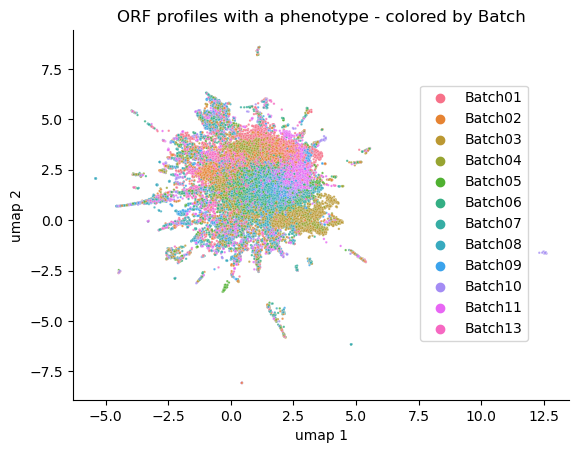

In [12]:
sns.scatterplot(
    data=X_embedded_orf_df,
    x="umap 1",
    y="umap 2",
    s=3,
    hue="Batch",
    hue_order=orf_batch_order,
    alpha=0.8,
).set_title(f"ORF profiles with a phenotype - colored by Batch")

sns.despine()
plt.legend(bbox_to_anchor=(0.7, 0.85), loc="upper left", borderaxespad=0, ncol=1)
plt.savefig(
    f"figures/orf_umap_phenotypic_activity_batch.png", bbox_inches="tight", dpi=300
)
plt.savefig(
    f"figures/orf_umap_phenotypic_activity_batch.svg", bbox_inches="tight", dpi=300
)

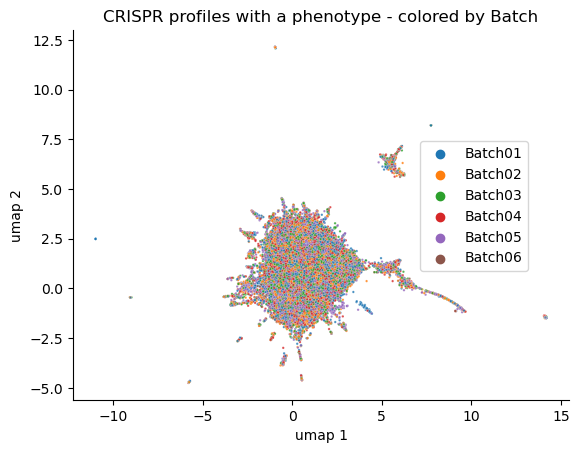

In [13]:
sns.scatterplot(
    data=X_embedded_crispr_df,
    x="umap 1",
    y="umap 2",
    s=3,
    hue="Batch",
    hue_order=crispr_batch_order,
    alpha=0.8,
).set_title(f"CRISPR profiles with a phenotype - colored by Batch")

sns.despine()
plt.legend(bbox_to_anchor=(0.7, 0.7), loc="upper left", borderaxespad=0, ncol=1)
plt.savefig(
    f"figures/crispr_umap_phenotypic_activity_batch.png", bbox_inches="tight", dpi=300
)
plt.savefig(
    f"figures/crispr_umap_phenotypic_activity_batch.svg", bbox_inches="tight", dpi=300
)

Colored by Row ID

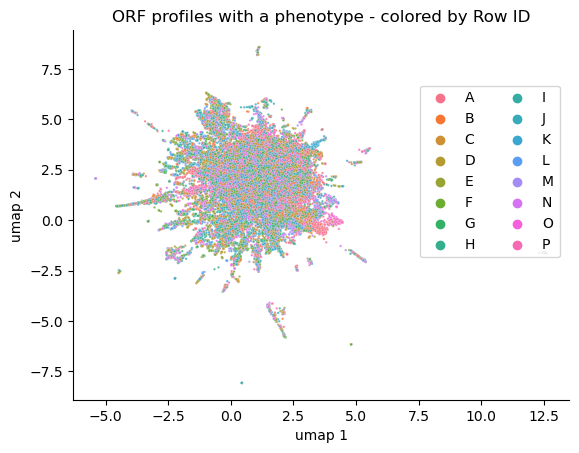

In [14]:
sns.scatterplot(
    data=X_embedded_orf_df,
    x="umap 1",
    y="umap 2",
    s=3,
    hue="Row",
    hue_order=row_order,
    alpha=0.8,
).set_title(f"ORF profiles with a phenotype - colored by Row ID")

sns.despine()
plt.legend(bbox_to_anchor=(0.7, 0.85), loc="upper left", borderaxespad=0, ncol=2)
plt.savefig(
    f"figures/orf_umap_phenotypic_activity_row.png", bbox_inches="tight", dpi=300
)
plt.savefig(
    f"figures/orf_umap_phenotypic_activity_row.svg", bbox_inches="tight", dpi=300
)

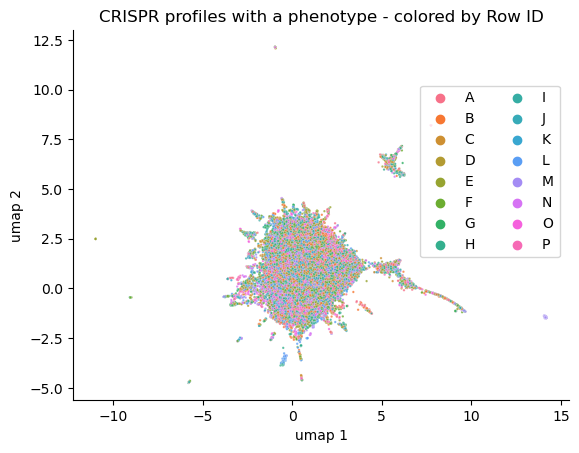

In [15]:
sns.scatterplot(
    data=X_embedded_crispr_df,
    x="umap 1",
    y="umap 2",
    s=3,
    hue="Row",
    hue_order=row_order,
    alpha=0.8,
).set_title(f"CRISPR profiles with a phenotype - colored by Row ID")

sns.despine()
plt.legend(bbox_to_anchor=(0.7, 0.85), loc="upper left", borderaxespad=0, ncol=2)
plt.savefig(
    f"figures/crispr_umap_phenotypic_activity_row.png", bbox_inches="tight", dpi=300
)
plt.savefig(
    f"figures/crispr_umap_phenotypic_activity_row.svg", bbox_inches="tight", dpi=300
)

Colored by Column ID

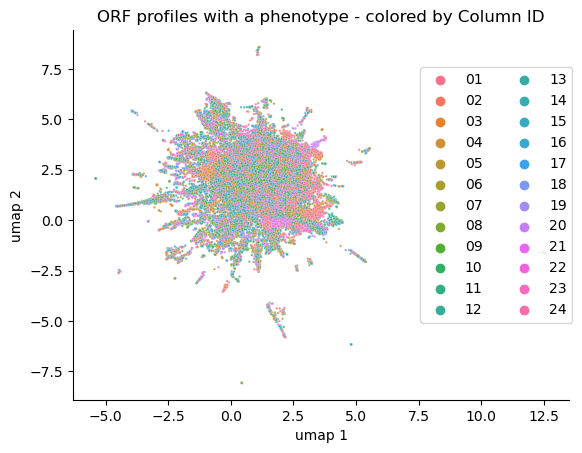

In [16]:
sns.scatterplot(
    data=X_embedded_orf_df,
    x="umap 1",
    y="umap 2",
    s=3,
    hue="Column",
    hue_order=column_order,
    alpha=0.8,
).set_title(f"ORF profiles with a phenotype - colored by Column ID")

sns.despine()
plt.legend(bbox_to_anchor=(0.7, 0.9), loc="upper left", borderaxespad=0, ncol=2)
plt.savefig(
    f"figures/orf_umap_phenotypic_activity_column.png", bbox_inches="tight", dpi=300
)
plt.savefig(
    f"figures/orf_umap_phenotypic_activity_column.svg", bbox_inches="tight", dpi=300
)

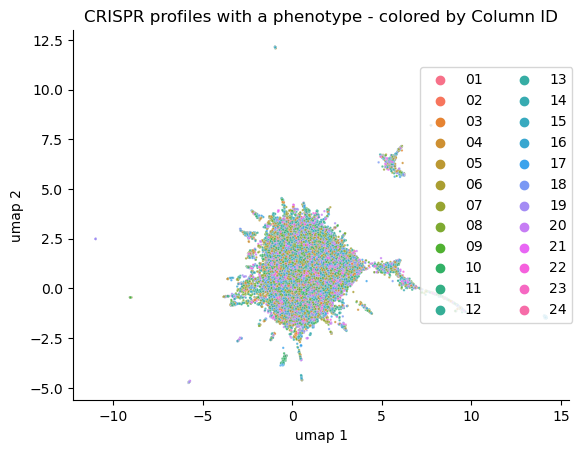

In [17]:
sns.scatterplot(
    data=X_embedded_crispr_df,
    x="umap 1",
    y="umap 2",
    s=3,
    hue="Column",
    hue_order=column_order,
    alpha=0.8,
).set_title(f"CRISPR profiles with a phenotype - colored by Column ID")

sns.despine()
plt.legend(bbox_to_anchor=(0.7, 0.9), loc="upper left", borderaxespad=0, ncol=2)
plt.savefig(
    f"figures/crispr_umap_phenotypic_activity_column.png", bbox_inches="tight", dpi=300
)
plt.savefig(
    f"figures/crispr_umap_phenotypic_activity_column.svg", bbox_inches="tight", dpi=300
)